# Introduction
In this notebook I will be working with a lead traders position history data from binance. Since binance does not offer an API endpoint for fetching this kind of data, I used a data miner to scrap the data. For privacy purposes,I will not be mentioning the lead traders name.The data  for the past 1 month is also publicly available at binance and so I believe this analysis does not violate any privacy.The purpose of this analysis is to:
1. Clean the  data
2. Perform EDA on the trade history - Identifying longest held trade, Highest loss and profit etc<br>
I will only remain with Symbol, Opened Time, Entry Price, Closing PNL, Closed Time and  Avg Close Price since these are only columns we will be working with.The data spans from 2024-04-29 upto 2025-03-08 with 1661 datasets.

### 1.Cleaning the Data

In [34]:
#Import required libraries
import pandas as pd
from datetime  import datetime
import matplotlib.pyplot as plt
import numpy as np

In [35]:
df_trade_history = pd.read_csv("../data/lead_traders_1M_tr.csv")
df_trade_history.shape

(1660, 8)

In [36]:
df_trade_history.head()

,Symbol,Opened Time,Entry Price,Max Open Interest,Closing PNL,Closed Time,Avg Close Price,Closed Volume
0,DOGEUSDT,2025-03-08 01:10:32,0.197453 USDT,"1,476 DOGE",+4.11 USDT,2025-03-08 04:02:19,0.200240 USDT,"1,476 DOGE"
1,1000PEPEUSDT,2025-03-08 01:10:32,0.0068907 USDT,"67,689 1000PEPE",+4.67 USDT,2025-03-08 07:48:41,0.0069597 USDT,"67,689 1000PEPE"
2,RENDERUSDT,2025-03-08 01:10:18,3.5697050 USDT,132.2 RENDER,+0.44 USDT,2025-03-08 07:35:43,3.5730000 USDT,132.2 RENDER
3,XRPUSDT,2025-03-08 00:55:38,2.3616 USDT,202.2 XRP,-1.01 USDT,2025-03-08 17:06:27,2.3566 USDT,202.2 XRP
4,SUIUSDT,2025-03-08 00:07:39,2.594085 USDT,185.7 SUI,+2.55 USDT,2025-03-08 07:26:27,2.607800 USDT,185.7 SUI


In [37]:
def clean_trade_history(filepath):
    df_trade_history = pd.read_csv(filepath)
    #Rename columns
    
    # Clean columns by removing "USDT" and stripping spaces, then convert to float
    cols_to_clean = ["Entry Price", "Closing PNL", "Avg Close Price"]
    df_trade_history[cols_to_clean] = df_trade_history[cols_to_clean].apply(
        lambda col: col.str.replace("USDT", "").str.strip()
    ).astype(float)

    # Rename columns 
    df_trade_history = df_trade_history.rename(columns={
        "Entry Price": "Entry Price (USDT)",
        "Avg Close Price": "Avg Close Price (USDT)",
        "Closing PNL": "Closing PnL (USDT)"
    })
    #Convert Closed Time & Closed Time to date time
    df_trade_history["Opened Time"] = pd.to_datetime(df_trade_history["Opened Time"])
    df_trade_history["Closed Time"] = pd.to_datetime(df_trade_history["Closed Time"])
    df_trade_history = df_trade_history[["Symbol","Opened Time", "Entry Price (USDT)", "Closing PnL (USDT)", "Closed Time","Avg Close Price (USDT)"]]
    return df_trade_history


In [38]:
df_trade_history = clean_trade_history("../data/lead_traders_1M_tr.csv")
df_trade_history.head()

,Symbol,Opened Time,Entry Price (USDT),Closing PnL (USDT),Closed Time,Avg Close Price (USDT)
0,DOGEUSDT,2025-03-08 01:10:32,0.197453,4.11,2025-03-08 04:02:19,0.20024
1,1000PEPEUSDT,2025-03-08 01:10:32,0.006891,4.67,2025-03-08 07:48:41,0.00696
2,RENDERUSDT,2025-03-08 01:10:18,3.569705,0.44,2025-03-08 07:35:43,3.57300
3,XRPUSDT,2025-03-08 00:55:38,2.361600,-1.01,2025-03-08 17:06:27,2.35660
4,SUIUSDT,2025-03-08 00:07:39,2.594085,2.55,2025-03-08 07:26:27,2.60780


In [39]:
df_trade_history.duplicated().sum()

0

### 2.Exploratory Data Analysis.
After cleaning the data and ensuring there were no duplicates, we now begin our Exploratory Data Analysis. Ofcourse we start with the basics like max profit and loss, profit to loss ratio etc

**Max profit & loss**

In [40]:
max_profit = df_trade_history["Closing PnL (USDT)"].max()
max_loss= df_trade_history["Closing PnL (USDT)"].min()
print(f"The highest profit made in the period was {max_profit} USDT and the highest loss was {max_loss} USDT.")

The highest profit made in the period was 152.89 USDT and the highest loss was -185.05 USDT.


**Longest held position held**

In [41]:
df_trade_history["Duration"] = df_trade_history["Closed Time"] - df_trade_history["Opened Time"]
df_trade_history.loc[df_trade_history["Duration"].idxmax()]

Symbol                           1000PEPEUSDT
Opened Time               2024-08-03 18:22:13
Entry Price (USDT)                   0.008406
Closing PnL (USDT)                       4.05
Closed Time               2024-08-09 01:07:23
Avg Close Price (USDT)               0.008487
Duration                      5 days 06:45:10
Name: 950, dtype: object

**Mean PnL per trade**


In [42]:
mean_pnl = df_trade_history["Closing PnL (USDT)"].mean()
print(f"Mean PnL per trade: {mean_pnl:.2f} USDT")


Mean PnL per trade: 3.37 USDT


**Standard Deviation of PnL per Trade**
    

In [43]:
std_pnl = df_trade_history["Closing PnL (USDT)"].std()
print(f"Standard Deviation of PnL per trade: {std_pnl:.2f} USDT")

Standard Deviation of PnL per trade: 17.18 USDT


**Sharpe Ratio (Per Trade)**<br>
-Risk adjusted metric<br>
Note: This assumes 0 risk-free rate

In [44]:
sharpe_trade = mean_pnl / std_pnl 
print(f"Sharpe Ratio per trade: {sharpe_trade:.2f}")


Sharpe Ratio per trade: 0.20


**Drawdown analysis** <br>
% Drawdown = (Current Value - Peak Value) / Peak Value<br>
Maximum Drawdown = Find the minimum value of the calculated drawdowns.
This minimum value (expressed as a negative percentage) represents the maximum drawdown.
From the analysis below the highest drawdown was -643 USDT and it occurred on Dec 22nd 2024.<br>
Maximum Drawdown Duration = Time taken to recover from the maximum drawdown to the previous peak value reached.
                

In [52]:
df_trade_history = df_trade_history.sort_values(["Closed Time", "Opened Time"])
df_trade_history = df_trade_history.reset_index(drop=True)
df_trade_history["Cumulative PnL"] = df_trade_history["Closing PnL (USDT)"].cumsum()
df_trade_history["Running Max"] = df_trade_history["Cumulative PnL"].cummax()
df_trade_history["Drawdown"] =df_trade_history["Cumulative PnL"]-df_trade_history["Running Max"]
max_drawdown = df_trade_history["Drawdown"].min()
print (f"Maximum drawdown experience by the lead trader is {round(max_drawdown, 1)} USDT")

Maximum drawdown experience by the lead trader is -643.9 USDT


,Symbol,Opened Time,Entry Price (USDT),Closing PnL (USDT),Closed Time,Avg Close Price (USDT),Duration,Cumulative PnL,Running Max,Drawdown
1252,APTUSDT,2024-12-21 14:26:09,10.21113,-148.29,2024-12-22 02:46:34,9.4436,0 days 12:20:25,2890.42,3534.33,-643.91


In [32]:
#Find when it occurred
drawdown_end_time = df_trade_history.loc[df_trade_history["Drawdown"].idxmin(), "Closed Time"]
print(f"Drawdown occurred on: {drawdown_end_time}")

Drawdown occurred on: 2024-12-22 02:46:34


### Visualizations
**Line plot for Drawdowns over time**<br>
Chart showed deep drawdowns experienced  near the end of Dec 2024 and at the beginning of march 2025.

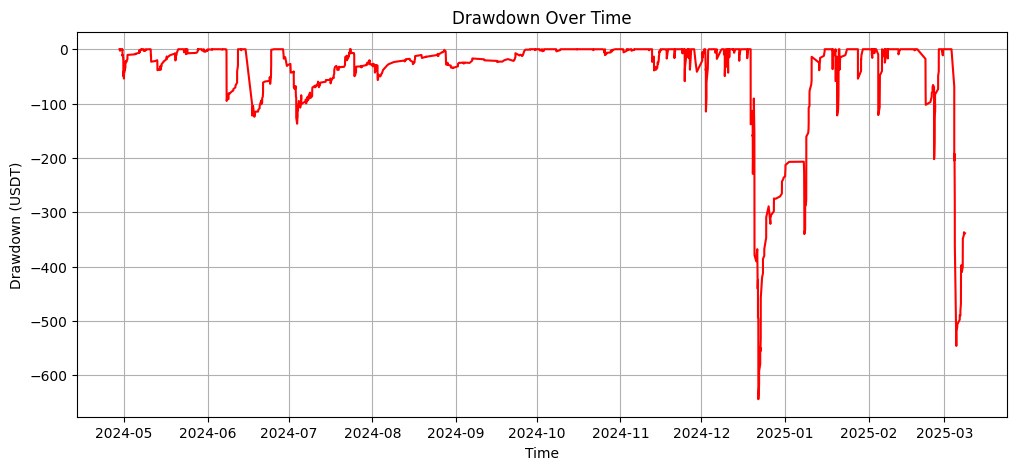

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(df_trade_history["Closed Time"], df_trade_history["Drawdown"], color="red")
plt.title("Drawdown Over Time")
plt.xlabel("Time")
plt.ylabel("Drawdown (USDT)")
plt.grid(True)
plt.show()


### Visualizations
**Line plot for cumulative pnl over time**<br>
The line plot of the cumulative pnl showed a steady return up to mid November 2024 where it rose sharply. Notice the sharp drawdowns on December 2024 and at the beginning of March 2025  as shown by our drawdown analysis we did previously.

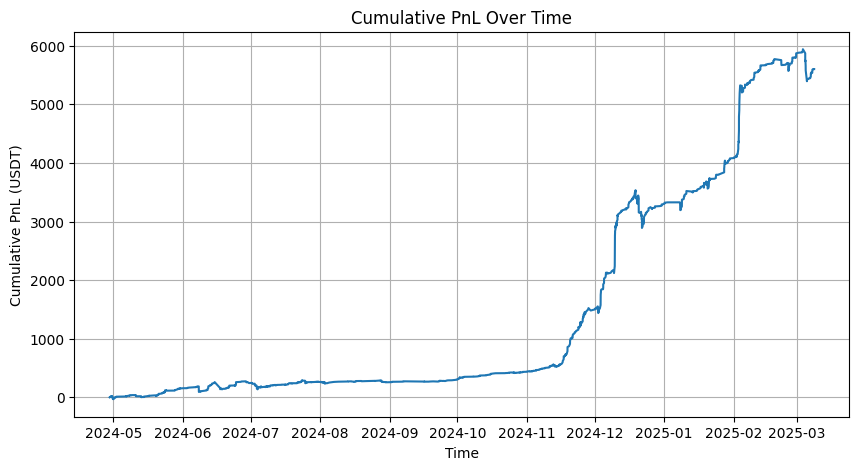

In [15]:

plt.figure(figsize=(10, 5))
plt.plot(df_trade_history["Closed Time"], df_trade_history["Cumulative PnL"])
plt.title("Cumulative PnL Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL (USDT)")
plt.grid(True)
plt.show()

**Histogram for distribution of profit and losses**<br>
    - Most trades are centered around zero meaning the lead trader closes at small profits and losses<br>
    - Slight right skew:<br>
     -There are more frequent small gains, but some outliers exist on both ends.<br>
     -The right tail (positive PnL) is longer, showing that while most gains are small, a few large positive trades occurred.<br>

    

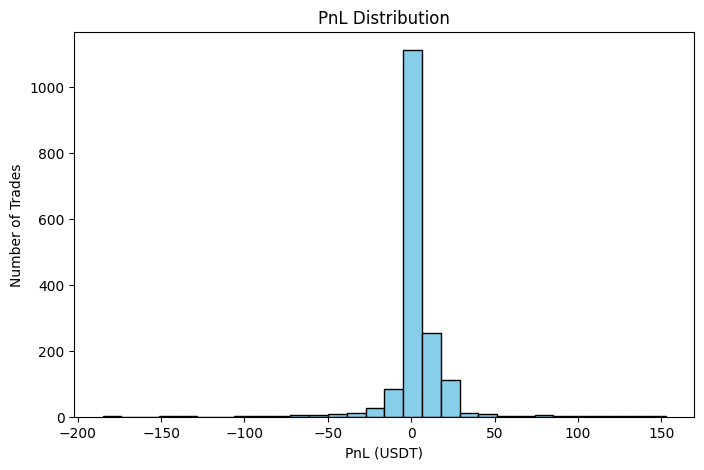

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(df_trade_history["Closing PnL (USDT)"], bins=30, color='skyblue', edgecolor='black')
plt.title("PnL Distribution")
plt.xlabel("PnL (USDT)")
plt.ylabel("Number of Trades")
plt.show()
